In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

In [2]:
# Load dataset
df = pd.read_csv('cnbc.csv')


In [3]:
# Praproses teks
max_features = 2000  # Jumlah kata yang akan di-tokenisasi
max_len = 300  # Panjang maksimum dari setiap sequence

tokenizer = Tokenizer(num_words=max_features, oov_token='<OOV>')
tokenizer.fit_on_texts(df['Stem_article'])
X = tokenizer.texts_to_sequences(df['Stem_article'])
X = pad_sequences(X, maxlen=max_len)

# Pastikan label biner
y = df['polarity'].values

In [4]:
# Menggabungkan X dan y untuk memudahkan undersampling
data = pd.DataFrame(X)
data['polarity'] = y

# Pisahkan kelas mayoritas dan minoritas
majority = data[data['polarity'] == 0]
minority = data[data['polarity'] == 1]


In [5]:
# Undersample kelas mayoritas
majority_undersampled = resample(majority,
                                 replace=False,  # Tidak mengganti sampel
                                 n_samples=len(minority),  # Cocokkan jumlah dengan kelas minoritas
                                 random_state=42)  # Untuk reproduktifitas

# Gabungkan kembali kelas mayoritas yang undersampled dengan kelas minoritas
undersampled_data = pd.concat([majority_undersampled, minority])

# Pisahkan kembali X dan y
X = undersampled_data.drop('polarity', axis=1).values
y = undersampled_data['polarity'].values


In [6]:
# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
# Hyperparameter tuning
def build_model(lstm_units, dropout_rate):
    model = Sequential([
        Embedding(input_dim=max_features, output_dim=128, input_length=max_len),
        SpatialDropout1D(dropout_rate),
        LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [8]:
# Hyperparameter grid
lstm_units_list = [50, 100, 150]
dropout_rate_list = [0.2, 0.3, 0.4]
batch_size_list = [32, 64]
epochs = 10

best_accuracy = 0
best_params = None
history_dict = {}

In [9]:
for lstm_units in lstm_units_list:
    for dropout_rate in dropout_rate_list:
        for batch_size in batch_size_list:
            print(f"Training model with LSTM units: {lstm_units}, Dropout rate: {dropout_rate}, Batch size: {batch_size}")
            model = build_model(lstm_units, dropout_rate)
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=2)
            score = model.evaluate(X_test, y_test, verbose=0)
            accuracy = score[1]
            print(f"Accuracy: {accuracy}")

            # Save the best model
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = (lstm_units, dropout_rate, batch_size)
                history_dict = history.history

print(f"Best hyperparameters - LSTM units: {best_params[0]}, Dropout rate: {best_params[1]}, Batch size: {best_params[2]}")
print(f"Best accuracy: {best_accuracy}")

Training model with LSTM units: 50, Dropout rate: 0.2, Batch size: 32


c:\Users\Anjelita Malik\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
26/26 - 19s - 716ms/step - accuracy: 0.5302 - loss: 0.6905 - val_accuracy: 0.5862 - val_loss: 0.6842
Epoch 2/10
26/26 - 27s - 1s/step - accuracy: 0.7349 - loss: 0.6053 - val_accuracy: 0.6453 - val_loss: 0.7170
Epoch 3/10
26/26 - 18s - 699ms/step - accuracy: 0.7928 - loss: 0.4979 - val_accuracy: 0.6749 - val_loss: 0.6223
Epoch 4/10
26/26 - 13s - 519ms/step - accuracy: 0.8570 - loss: 0.3796 - val_accuracy: 0.6847 - val_loss: 0.6316
Epoch 5/10
26/26 - 11s - 406ms/step - accuracy: 0.8964 - loss: 0.2825 - val_accuracy: 0.6847 - val_loss: 0.6748
Epoch 6/10
26/26 - 5s - 199ms/step - accuracy: 0.9038 - loss: 0.2557 - val_accuracy: 0.6650 - val_loss: 0.7115
Epoch 7/10
26/26 - 5s - 195ms/step - accuracy: 0.9236 - loss: 0.2028 - val_accuracy: 0.6749 - val_loss: 0.7780
Epoch 8/10
26/26 - 5s - 196ms/step - accuracy: 0.9470 - loss: 0.1607 - val_accuracy: 0.6355 - val_loss: 0.8386
Epoch 9/10
26/26 - 13s - 519ms/step - accuracy: 0.9396 - loss: 0.1545 - val_accuracy: 0.6552 - val_loss: 0.943

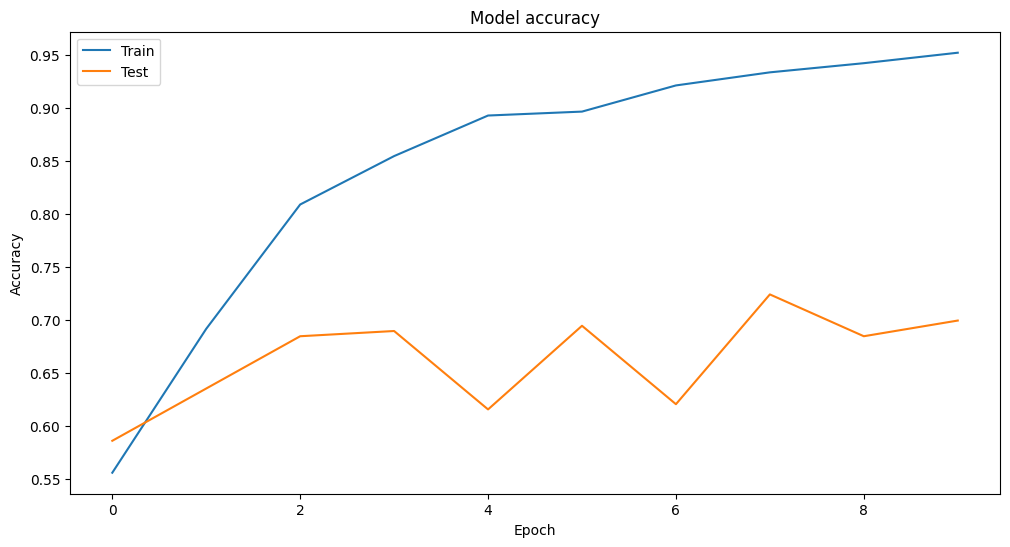

In [10]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


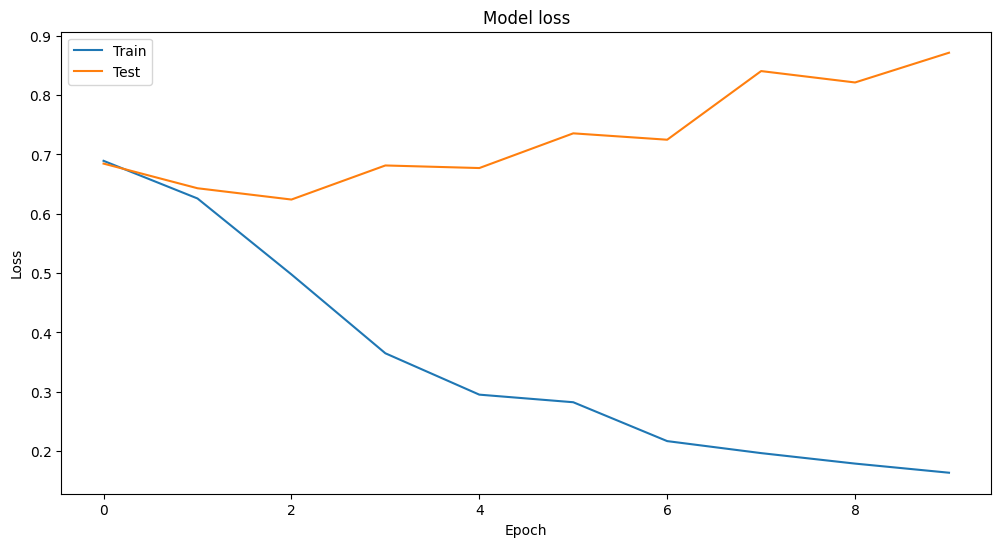

In [11]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [12]:
# Evaluasi model terbaik
model = build_model(*best_params[:2])
model.fit(X_train, y_train, epochs=epochs, batch_size=best_params[2], validation_data=(X_test, y_test), verbose=2)
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Loss: {score[0]}')
print(f'Accuracy: {score[1]}')


Epoch 1/10
13/13 - 20s - 2s/step - accuracy: 0.5524 - loss: 0.6919 - val_accuracy: 0.5517 - val_loss: 0.6892
Epoch 2/10
13/13 - 9s - 661ms/step - accuracy: 0.7041 - loss: 0.6649 - val_accuracy: 0.5862 - val_loss: 0.6692
Epoch 3/10
13/13 - 9s - 661ms/step - accuracy: 0.7090 - loss: 0.5787 - val_accuracy: 0.6749 - val_loss: 0.6105
Epoch 4/10
13/13 - 12s - 885ms/step - accuracy: 0.8286 - loss: 0.4131 - val_accuracy: 0.6404 - val_loss: 0.6767
Epoch 5/10
13/13 - 13s - 976ms/step - accuracy: 0.8767 - loss: 0.3456 - val_accuracy: 0.6453 - val_loss: 0.6675
Epoch 6/10
13/13 - 9s - 666ms/step - accuracy: 0.8964 - loss: 0.3098 - val_accuracy: 0.6700 - val_loss: 0.7782
Epoch 7/10
13/13 - 8s - 607ms/step - accuracy: 0.8644 - loss: 0.3572 - val_accuracy: 0.6305 - val_loss: 0.6872
Epoch 8/10
13/13 - 7s - 503ms/step - accuracy: 0.9260 - loss: 0.2468 - val_accuracy: 0.7143 - val_loss: 0.7716
Epoch 9/10
13/13 - 8s - 581ms/step - accuracy: 0.9248 - loss: 0.2165 - val_accuracy: 0.6749 - val_loss: 0.7840
E

In [13]:
# Prediksi
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Evaluasi hasil prediksi
cm = confusion_matrix(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step
[[67 29]
 [29 78]]
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        96
           1       0.73      0.73      0.73       107

    accuracy                           0.71       203
   macro avg       0.71      0.71      0.71       203
weighted avg       0.71      0.71      0.71       203



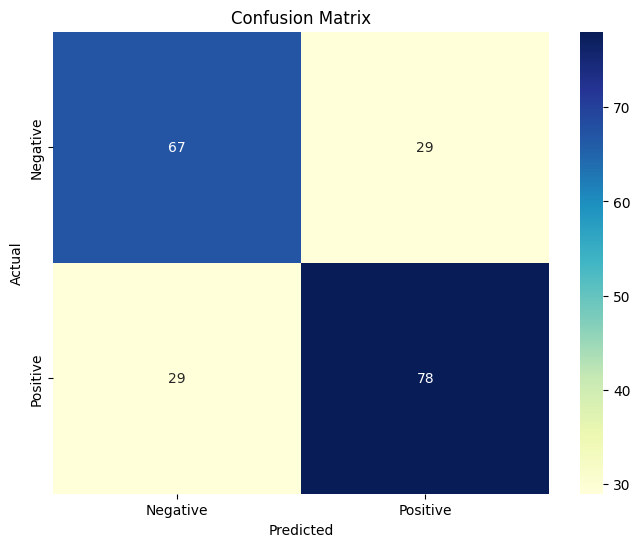

In [14]:
# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [15]:
# Summarize the model
model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ (None, 300, 128)       │       256,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_18            │ (None, 300, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 100)            │        91,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,043,105 (3.98 MB)

 Trainable params: 347,701 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 695,404 (2.65 MB)

In [3]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from wordcloud import WordCloud
import re

[nltk_data] Downloading package punkt to C:\Users\Anjelita
[nltk_data]     Malik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
sentiment_pos = ' '.join([review for review in df['Pre'][df['polarity'] == 1]])

# create object wordcloud
w_pos = WordCloud(background_color="white",
                  width=800, height=300, max_font_size=200,
                  max_words=500).generate(sentiment_pos)

plt.figure(figsize=(14,8))
plt.axis("off")
plt.tight_layout()
plt.imshow(w_pos, interpolation="bilinear")
plt.show()